# 라이브러리 호출

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from tensorflow.keras import layers, models, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Conv2DTranspose, UpSampling2D, BatchNormalization, Activation, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
# 한글 폰트 설정
font_path = "C:/Windows/Fonts/malgun.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
import numpy as np
import pandas as pd
import os

# Data summary

학습 데이터 - 불량: 59, 정상: 1102
테스트 데이터 - 불량: 15, 정상: 276
전체 데이터 - 불량: 74, 정상: 1378


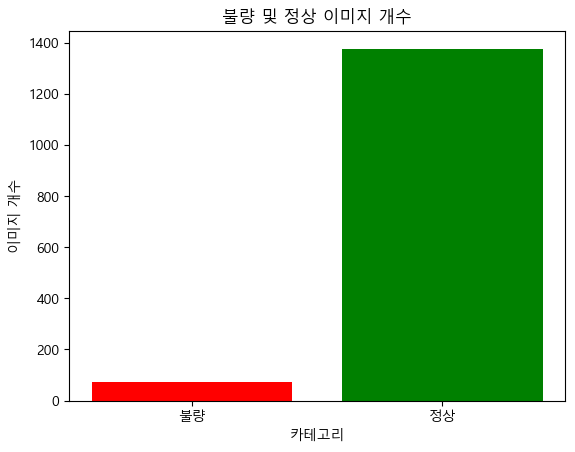

In [3]:
# 디렉토리 경로 설정
base_dir = 'data/resized'
train_defective_dir = os.path.join(base_dir, '학습', '불량')
train_normal_dir = os.path.join(base_dir, '학습', '정상')
test_defective_dir = os.path.join(base_dir, '테스트', '불량')
test_normal_dir = os.path.join(base_dir, '테스트', '정상')

# 각 디렉토리의 이미지 개수 계산
num_train_defective = len(os.listdir(train_defective_dir))
num_train_normal = len(os.listdir(train_normal_dir))
num_test_defective = len(os.listdir(test_defective_dir))
num_test_normal = len(os.listdir(test_normal_dir))

# 전체 개수 계산
total_defective = num_train_defective + num_test_defective
total_normal = num_train_normal + num_test_normal

# 결과 출력
print(f"학습 데이터 - 불량: {num_train_defective}, 정상: {num_train_normal}")
print(f"테스트 데이터 - 불량: {num_test_defective}, 정상: {num_test_normal}")
print(f"전체 데이터 - 불량: {total_defective}, 정상: {total_normal}")

# 시각화
categories = ['불량', '정상']
counts = [total_defective, total_normal]

plt.bar(categories, counts, color=['red', 'green'])
plt.title('불량 및 정상 이미지 개수')
plt.xlabel('카테고리')
plt.ylabel('이미지 개수')
plt.show()


In [4]:
# 이미지 전처리 함수 정의 (타겟 사이즈: 512x512, RGB)
def preprocess_images(image_dir, target_size=(512, 512)):
    images = []
    for filename in os.listdir(image_dir):
        img_path = os.path.join(image_dir, filename)
        img = load_img(img_path, color_mode='rgb', target_size=target_size)
        img_array = img_to_array(img) / 255.0  # 정규화 (0~1)
        images.append(img_array)
    return np.array(images)

In [5]:
# 학습 및 테스트 데이터 로드
train_defective_images = preprocess_images(train_defective_dir)
train_normal_images = preprocess_images(train_normal_dir)
test_defective_images = preprocess_images(test_defective_dir)
test_normal_images = preprocess_images(test_normal_dir)

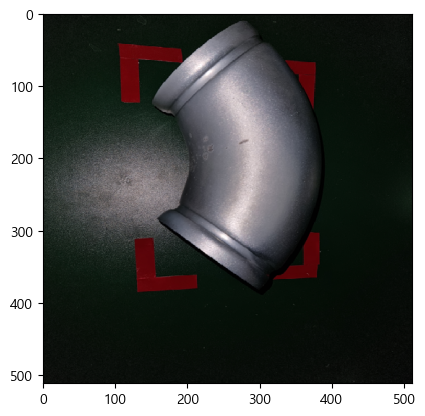

In [7]:
plt.imshow(test_defective_images[3])

# 데이터 증강

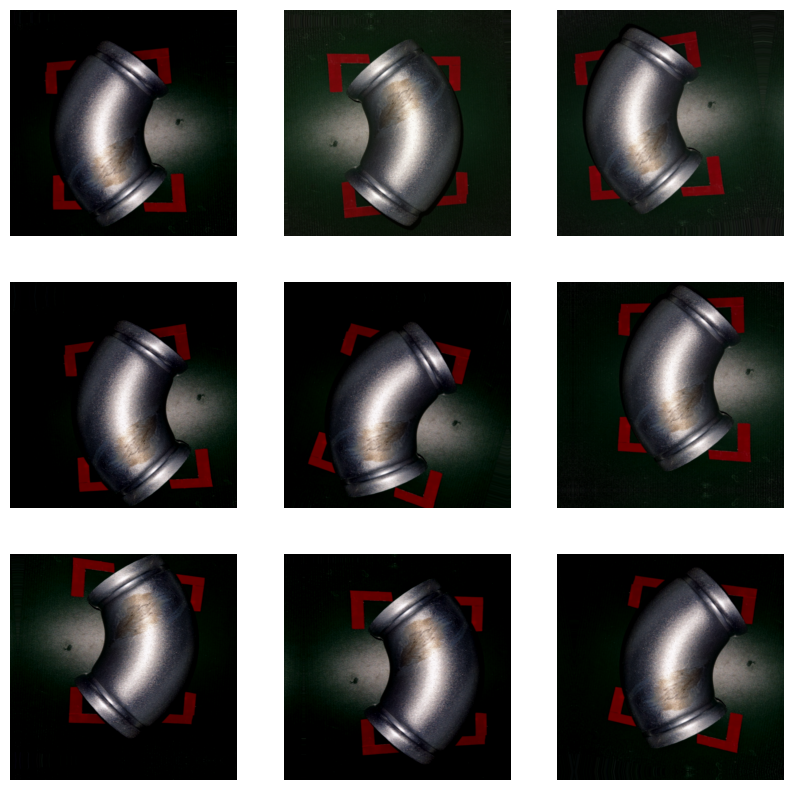

In [8]:
# Define augmentation pipeline with safe ranges
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.05, fill_mode='nearest'),
    layers.RandomTranslation(0.1, 0.1, fill_mode='reflect'),
    layers.RandomContrast(factor=(0.9, 1.1)),
    layers.GaussianNoise(0.01)   # Add low-level noise for robustness
])

# Load and preprocess image function
def load_and_preprocess_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [512, 512])
    img = tf.cast(img, tf.float32) / 255.0
    return img

# Visualize augmented images
def visualize_augmented_images(file_paths):
    plt.figure(figsize=(10, 10))
    for i, file_path in enumerate(file_paths[:9]):
        img = load_and_preprocess_image(file_path)  # Load and preprocess image
        augmented_img = data_augmentation(tf.expand_dims(img, axis=0))  # Apply augmentation
        plt.subplot(3, 3, i + 1)
        plt.imshow(tf.keras.utils.array_to_img(augmented_img[0]))  # Convert back to image for visualization
        plt.axis('off')
    plt.show()

# Example dataset of file paths
file_paths = ["data/resized/학습/불량/KEMP_IMG_DATA_Error_2.png"] * 9

# Visualize augmented images from file paths
visualize_augmented_images(file_paths)


In [9]:
# Generate 5000 augmented images
augmented_images = []
for _ in range(1000):
    idx = np.random.randint(len(train_defective_images))  # Randomly select an image
    img = train_defective_images[idx]
    augmented_img = data_augmentation(img[None, ...], training=True)  # Apply augmentation
    augmented_images.append(augmented_img.numpy()[0])  # Remove batch dimension

# Convert to numpy array
augmented_images = np.array(augmented_images)

# Combine original and augmented datasets
train_defective_images_updated = np.concatenate((train_defective_images, augmented_images), axis=0)

# Check the updated dataset shape
print(f"Updated dataset shape: {train_defective_images_updated.shape}")

Updated dataset shape: (1059, 512, 512, 3)


In [10]:
# 라벨 생성 (불량: 0, 정상: 1)
train_labels_defective = np.zeros(len(train_defective_images_updated))
train_labels_normal = np.ones(len(train_normal_images))

In [11]:
combined_images = np.concatenate((train_defective_images_updated, train_normal_images), axis=0)
combined_labels = np.concatenate((train_labels_defective, train_labels_normal), axis=0)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    combined_images, combined_labels, test_size=0.2, random_state=42, stratify=combined_labels
)

In [13]:
# Check the shapes of the resulting datasets
print(f"Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, Testing labels shape: {y_test.shape}")

Training data shape: (1728, 512, 512, 3), Training labels shape: (1728,)
Testing data shape: (433, 512, 512, 3), Testing labels shape: (433,)


# 학습

In [14]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(512, 512, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

c:\Users\gh159\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 510, 510, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 255, 255, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 253, 253, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 126, 126, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 124, 124, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 62, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 492032)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    62,980,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 189,220,805 (721.82 MB)

 Trainable params: 63,073,601 (240.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 126,147,204 (481.21 MB)

In [15]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [16]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    shuffle=True
)

Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.8152 - loss: 1.0804 - val_accuracy: 0.9971 - val_loss: 0.0104
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.9872 - loss: 0.0394 - val_accuracy: 1.0000 - val_loss: 0.0083
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.9925 - loss: 0.0215 - val_accuracy: 0.9971 - val_loss: 0.0090
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.9968 - loss: 0.0124 - val_accuracy: 1.0000 - val_loss: 9.1236e-04
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.9992 - loss: 0.0017 - val_accuracy: 0.9971 - val_loss: 0.0052
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.9880 - loss: 0.0467 - val_accuracy: 1.0000 - val_loss: 5.4917e-06
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.9916 - loss: 0.0231 - val_accuracy: 1.0000 - val_loss: 0.0017
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 1.0000 - v

In [17]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 305ms/step - accuracy: 1.0000 - loss: 2.1568e-05
Test Loss: 1.6186748325708322e-05
Test Accuracy: 1.0


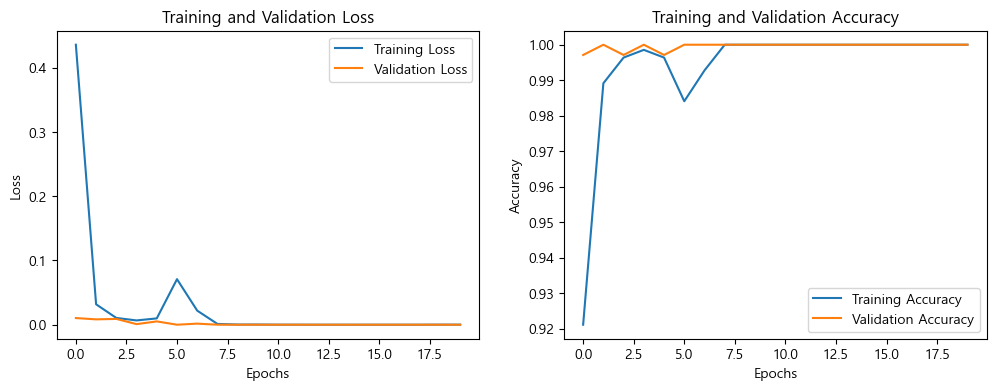

In [21]:
# 학습 성능 그래프
plt.figure(figsize=(12, 4))

# Training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [20]:
model.save('my_model.keras')

# 테스트 데이터 활용 검증

In [22]:
# Generate 200 augmented images
augmented_test_images = []
for _ in range(200):
    idx = np.random.randint(len(test_defective_images))  # Randomly select an image
    img = test_defective_images[idx]
    augmented_test_img = data_augmentation(img[None, ...], training=True)  # Apply augmentation
    augmented_test_images.append(augmented_test_img.numpy()[0])  # Remove batch dimension

# Convert to numpy array
augmented_test_images = np.array(augmented_test_images)

# Combine original and augmented datasets
test_defective_images_updated = np.concatenate((test_defective_images, augmented_test_images), axis=0)

# Check the updated dataset shape
print(f"Updated dataset shape: {test_defective_images_updated.shape}")

Updated dataset shape: (215, 512, 512, 3)


In [23]:
# 라벨 생성 (불량: 0, 정상: 1)
test_labels_defective = np.zeros(len(test_defective_images_updated))
test_labels_normal = np.ones(len(test_normal_images))

In [24]:
combined_test_images = np.concatenate((test_defective_images_updated, test_normal_images), axis=0)
combined_test_labels = np.concatenate((test_labels_defective, test_labels_normal), axis=0)

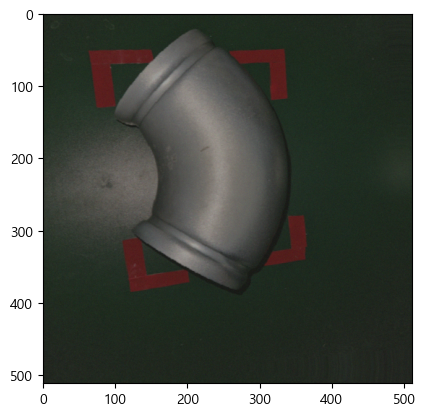

In [32]:
plt.imshow(combined_test_images[80])

In [25]:
# 모델 평가
test_loss, test_accuracy = model.evaluate(combined_test_images, combined_test_labels)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 252ms/step - accuracy: 1.0000 - loss: 2.6687e-05
Test Loss: 8.768978659645654e-06
Test Accuracy: 1.0
